## REINFORCE: REINFORCE without Baseline

使用模型古算Baseline，Q减去Baseline模型的计算结果

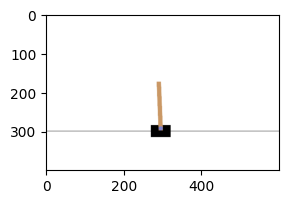

In [17]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [18]:
import torch
	
#定义模型, 计算每个动作的概率
model_action = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
	torch.nn.Softmax(dim=1),
)

# code changed
# 基线模型，评估state的价值
model_baseline = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)
model_action, model_baseline

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
   (5): Softmax(dim=1)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=1, bias=True)
 ))

In [19]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
	state = []
	action = []
	reward = []

	s = env.reset()
	o = False
	while not o:
		# 根据环境采样
		prob = model_action(torch.FloatTensor(s).reshape(1, 4))[0].tolist() # code changed
		a = random.choices(range(2), weights=prob, k=1)[0]
		
		ns, r, o = env.step(a)

		state.append(s)
		action.append(a)
		reward.append(r)
  
		s = ns

		if show:
			display.clear_output(wait=True)
			env.show()
  
	state = torch.FloatTensor(state).reshape(-1, 4)
	action = torch.LongTensor(action).reshape(-1, 1)
	reward = torch.FloatTensor(reward).reshape(-1, 1)

	return state, action, reward, reward.sum().item()

state, action, reward, reward_sum = play()

reward_sum

-989.0

In [20]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-3)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=5e-4)

In [21]:
def get_value(reward):
  # 计算当前state的价值，其实就是Q(state, action)
  # 这里用MC估计
  value = []
  for i in range(len(reward)):
    s = 0
    for j in range(i, len(reward)):
      s += reward[j] * 0.99 ** (j - i)
    value.append(s)
  
  return torch.FloatTensor(value).reshape(-1, 1)

value = get_value(reward)
value.shape

torch.Size([12, 1])

In [22]:
# baseline 模型训练
def train_baseline(state, value):
  baseline = model_baseline(state)
  
  loss = torch.nn.functional.mse_loss(baseline, value)
  loss.backward()
  optimizer_baseline.step()
  optimizer_baseline.zero_grad()
  
  return baseline.detach()

baseline = train_baseline(state, value)
baseline.shape

torch.Size([12, 1])

In [23]:
# 训练action
def train_action(state, action, value, baseline):
  # 重新计算动作概率
  prob = model_action(state).gather(dim=1, index=action)
  
  # 求Q导数 -> partial value / partial action
  # Q使用前去基线
  prob = (prob + 1e-8).log() * (value - baseline)
  for i in range(len(prob)):
    prob[i] = prob[i] * 0.99 ** i
  loss = -prob.mean()
  
  loss.backward()
  optimizer_action.step()
  optimizer_action.zero_grad()
  
  return loss.item()

train_action(state, action, value, baseline)

-617.1893920898438

In [24]:
#训练
def train():
	model_action.train()
	model_baseline.train()

	# 共更新N轮数据
	for epoch in range(1000):
		# 一个epoch玩N步
		steps = 0
		while steps < 200:
			# 玩一局，得到数据
			state, action, reward, _ = play()
			steps += len(state)

			# 训练两个模型
			value = get_value(reward)
			baseline = train_baseline(state, value)
			loss = train_action(state, action, value, baseline)

		if epoch % 100 == 0:
			test_result = sum([play()[-1] for _ in range(20)]) / 20
			print(epoch, loss, test_result)

train()

0 -455.1480712890625 -986.45
100 17.918447494506836 200.0
200 17.183107376098633 96.5
300 19.394990921020508 200.0
400 16.4073429107666 200.0
500 17.5371150970459 200.0
600 16.228199005126953 200.0
700 17.210519790649414 200.0
800 14.769414901733398 200.0
900 13.420842170715332 200.0


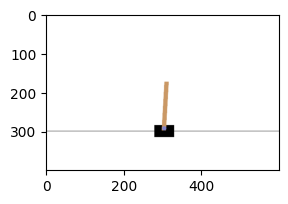

200.0

In [25]:
play(True)[-1]